In [1]:
# load yolov3 model and perform object detection
# based on https://github.com/experiencor/keras-yolo3
import numpy as np
from numpy import expand_dims
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle

class BoundBox:
	def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		self.objness = objness
		self.classes = classes
		self.label = -1
		self.score = -1

	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)

		return self.label

	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]

		return self.score

def _sigmoid(x):
	return 1. / (1. + np.exp(-x))

def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
	netout[..., 5:] *= netout[..., 5:] > obj_thresh

	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			# 4th element is objectness score
			objectness = netout[int(row)][int(col)][b][4]
			if(objectness.all() <= obj_thresh): continue
			# first 4 elements are x, y, w, and h
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w # center position, unit: image width
			y = (row + y) / grid_h # center position, unit: image height
			w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
			h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
			# last elements are class probabilities
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes

def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
	new_w, new_h = net_w, net_h
	for i in range(len(boxes)):
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
		boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
		boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
		boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
		boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3

def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union

def do_nms(boxes, nms_thresh):
	if len(boxes) > 0:
		nb_class = len(boxes[0].classes)
	else:
		return
	for c in range(nb_class):
		sorted_indices = np.argsort([-box.classes[c] for box in boxes])
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].classes[c] == 0: continue
			for j in range(i+1, len(sorted_indices)):
				index_j = sorted_indices[j]
				if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
					boxes[index_j].classes[c] = 0

# load and prepare an image
def load_image_pixels(filename, shape):
	# load the image to get its shape
	image = load_img(filename)
	width, height = image.size
	# load the image with the required size
	image = load_img(filename, target_size=shape)
	# convert to numpy array
	image = img_to_array(image)
	# scale pixel values to [0, 1]
	image = image.astype('float32')
	image /= 255.0
	# add a dimension so that we have one sample
	image = expand_dims(image, 0)
	return image, width, height

# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	# enumerate all boxes
	for box in boxes:
		# enumerate all possible labels
		for i in range(len(labels)):
			# check if the threshold for this label is high enough
			if box.classes[i] > thresh:
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
				# don't break, many labels may trigger for one box
	return v_boxes, v_labels, v_scores

# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
	# load the image
	data = pyplot.imread(filename)
	# plot the image
	pyplot.imshow(data)
	# get the context for drawing boxes
	ax = pyplot.gca()
	# plot each box
	for i in range(len(v_boxes)):
		box = v_boxes[i]
		# get coordinates
		y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
		# calculate width and height of the box
		width, height = x2 - x1, y2 - y1
		# create the shape
		rect = Rectangle((x1, y1), width, height, fill=False, color='white')
		# draw the box
		ax.add_patch(rect)
		# draw text and score in top left corner
		label = "%s (%.3f)" % (v_labels[i], v_scores[i])
		pyplot.text(x1, y1, label, color='white')
	# show the plot
	pyplot.show()



In [34]:
def pred_yolo(fname):
    # load yolov3 model
    input_w, input_h = 416, 416
    image, image_w, image_h = load_image_pixels(fname, (input_w, input_h))
    model = load_model('yolov3_pre_trained.h5')
    # define the expected input shape for the model
    # define our new photo

    yhat = model.predict(image)
    # summarize the shape of the list of arrays
    #print([a.shape for a in yhat])
    # define the anchors
    anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
    # define the probability threshold for detected objects
    class_threshold = 0.6
    boxes = list()
    for i in range(len(yhat)):
        # decode the output of the network
        boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
    # correct the sizes of the bounding boxes for the shape of the image
    correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
    # suppress non-maximal boxes
    do_nms(boxes, 0.5)
    # define the labels
    labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
        "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
        "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
        "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
        "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
        "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
        "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
        "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
        "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
        "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
    # get the details of the detected objects
    v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
    return v_boxes, v_labels, v_scores


car 93.74997615814209
car 96.58799767494202
car 88.22624087333679
car 84.40198302268982
car 86.15414500236511
car 81.20998740196228
car 78.21272015571594
car 73.70765805244446
car 89.76585865020752
person 92.53706336021423
car 65.1323139667511
car 73.68414402008057
car 96.73409461975098


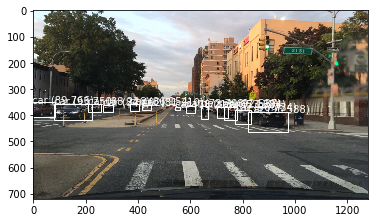

In [35]:
photo_filename = './Data/bdd100k/images/tmp/b1c66a42-6f7d68ca-0000001.jpg'

v_boxes, v_labels, v_scores =pred_yolo(photo_filename)
# summarize what we found
for i in range(len(v_boxes)):
	print(v_labels[i], v_scores[i])
# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

In [6]:
import json
json_path='./Data/bdd100k/labels/detection20/det_v2_val_release.json'
with open (json_path) as json_file:
    dat=json.load(json_file)

In [12]:
import glob
image_names =  glob.glob('./Data/bdd100k/images/*.jpg')

image_list=[]
loss_list=[]
for i,fname in enumerate(image_names[:100]):
#    image, image_w, image_h = load_image_pixels(fname, (input_w, input_h))
    f_id=fname.split('images/')[-1].split('-0000001.jpg')[0]
    idx=np.where([d['videoName']==f_id for d in dat])[0][0]
    target_list=[obj['category'] for obj in dat[idx]['labels']]
    
    v_boxes, v_labels, v_scores = pred_yolo(fname)
    true_label = np.array(np.isin(v_labels, target_list))

    pred_loss = np.mean(-(true_label.T*np.log10(np.array(v_scores)/100)+(1-true_label.T)*np.log10(1-np.array(v_scores)/100)))
    image_list.append(image)
    loss_list.append(pred_loss)
    print(i)
    
print(loss_list)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
[0.13270248104514182, 0.5962733256076233, 0.43608334127152454, 0.4150352066271816, 0.08841834644690745, 0.233628127115938, 0.11061127314635555, 0.07362696973069303, 0.2391392687649171, nan, 0.01723239223204743, 0.14847930609648638, 0.42404480606394046, 0.037826230537950895, 0.080686938504215, 0.06799692568422931, 0.20819117468530973, 0.06363231253647425, 0.05185234829473962, 0.0927881269417516, 0.2044538724124986, 1.2306337316250897, 0.13567518189896105, 0.26334612282964176, 0.14445431892494084, 0.10936854069100727, 0.05583811697126833, 0.26460725695544385, 0.09250744193917128, 0.07016925673774188, nan, 0.059077490549048345, 0.5673294338329138, 0.0012491878780986113, 0.061320907441555945, 0.3331068083

In [16]:
x=np.stack(image_list,0)
y=np.array(loss_list)
np.save('./x.npy',x)
np.save('./y.npy',y)

In [ ]:
#idx=np.where([d['videoName']=='b1c66a42-6f7d68ca' for d in dat])[0]
#b1c66a42-6f7d68ca
#image_names[0].split('s/')[-1].split('-0')[-1]
#import os
#for d in dat:
#    fname=d['videoName']
#    os.system('wget'+' http://dl.yf.io/bdd100k/frames/'+fname+'/'+fname+'-0000001.jpg --directory-prefix=./Data/bdd100k/images/')